Problem statement: To build a CNN based model which can accurately classify 9 different types of skin cancers. Malignant skin cancer is a type of cancer that can be deadly if not detected early. Melanoma accounts for 75% of skin cancer deaths. A solution which can evaluate images and allow the dermatologists to prescribe the correct line of treatment. This solution has the potential to reduce a lot of manual effort needed in diagnosis.

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7481865/

### Importing Skin Cancer Data
#### Take necessary actions to read the data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import tensorflow.keras.backend as K

In [2]:
from glob import glob

In [3]:
# ## If one is using the data by mounting the google drive, use the following :
# from google.colab import drive
# drive.mount('/content/drive')

# ##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

In [4]:
# !unzip /content/drive/MyDrive/Academics/CNN_assignment.zip

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [5]:
# Defining the path for train and test images
## Update the paths of the train and test dataset

data_dir_train = pathlib.Path("Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path("Skin cancer ISIC The International Skin Imaging Collaboration/Test")

In [6]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [7]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [8]:
## Train dataset
## We have used seed=123 while creating our dataset using tf.keras.preprocessing.image_dataset_from_directory

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed = 123,
    validation_split= 0.2,
    subset= 'training',
    image_size=(img_height, img_width),
    batch_size = batch_size
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [9]:
## Validation dataset

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed = 123,
    validation_split = 0.2,
    subset= 'validation',
    image_size=(img_height,img_width),
    batch_size = batch_size
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [10]:
# List out all the classes of skin cancer and store them in a list. 
# One can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Create a code to visualize one instance of all the nine classes present in the dataset

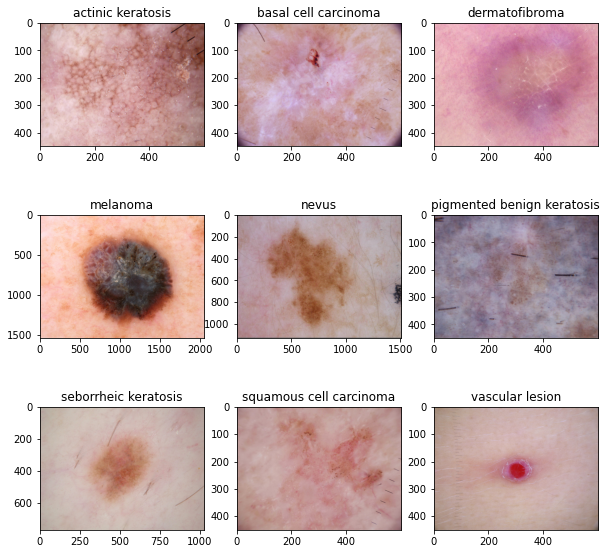

In [11]:
import matplotlib.pyplot as plt

import matplotlib.image as mpimg
plt.figure(figsize=(10,10))
for i in range(9): 
  plt.subplot(3, 3, i + 1)
  image = mpimg.imread(str(list(data_dir_train.glob(class_names[i]+'/*.jpg'))[2]))
  plt.title(class_names[i])
  plt.imshow(image)

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [12]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [13]:
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D

def build_model(hp):  
  model = keras.Sequential([keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))])
      
  model.add(Conv2D(
        filters=hp.Int('conv_1_filter', min_value = 32, max_value = 128, step = 16),
        kernel_size=hp.Choice('conv_1_kernel', values = [3,5]),
        activation='relu',
        input_shape=(180, 180, 3, 32)
    )),
  model.add(Conv2D(
        filters=hp.Int('conv_2_filter', min_value=32, max_value=128, step=16),
        kernel_size=hp.Choice('conv_2_kernel', values = [3,5]),
        activation='relu'
    )),
  model.add(MaxPool2D(pool_size=(2,2))),
    
  model.add(Conv2D(
        filters=hp.Int('conv_3_filter', min_value=32, max_value=128, step=16),
        kernel_size=hp.Choice('conv_3_kernel', values = [3,5]),
        activation='relu'
    )),
  model.add(MaxPool2D(pool_size=(2,2))),
    
  model.add(Conv2D(
        filters=hp.Int('conv_4_filter', min_value=32, max_value=128, step=16),
        kernel_size=hp.Choice('conv_4_kernel', values = [3,5]),
        activation='relu'
    )),
  model.add(MaxPool2D(pool_size=(2,2))),
                           
  model.add(Flatten()),
  model.add(Dense(
        units=hp.Int('dense_1_units', min_value=32, max_value=128, step=16),
        activation='relu'
    )),
  model.add(Dense(9, activation='softmax'))
  
  model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3])),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
  
  return model

In [14]:
from keras_tuner import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters

In [15]:
tuner_search=RandomSearch(build_model, objective='accuracy', max_trials = 10,directory='trial_output',
                          project_name="DMML2_CA1")

In [16]:
tuner_search.search(train_ds, epochs=20)

Trial 10 Complete [00h 00m 59s]
accuracy: 0.7745535969734192

Best accuracy So Far: 0.8264508843421936
Total elapsed time: 00h 12m 50s
INFO:tensorflow:Oracle triggered exit


In [17]:
model=tuner_search.get_best_models(num_models=1)[0]

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 176, 176, 96)      7296      
                                                                 
 conv2d_1 (Conv2D)           (None, 172, 172, 96)      230496    
                                                                 
 max_pooling2d (MaxPooling2D  (None, 86, 86, 96)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 82, 82, 96)        230496    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 41, 41, 96)       0         
 2D)                                                    

In [ ]:
# Since 'model' has not been evaluated on the customized metric 'recall', we would run the same model and compile it with
# accuracy as well as recall:

In [28]:
# Creating a simple CNN model (without dropouts and batch normalization):

from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.layers import Activation

num_classes = 9

model_1 = Sequential([
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))
                  ])


model_1.add(Conv2D(filters = 96, kernel_size = (5,5), padding = 'Same', activation ='relu', input_shape = (180, 180, 3, 32)))
model_1.add(Conv2D(filters = 96, kernel_size = (5,5), padding = 'Same', activation ='relu'))
model_1.add(MaxPool2D(pool_size=(2,2)))

model_1.add(Conv2D(filters = 96, kernel_size = (5,5), padding = 'Same', activation ='relu'))
model_1.add(MaxPool2D(pool_size=(2,2)))

model_1.add(Conv2D(filters = 64, kernel_size = (5,5), padding = 'Same', activation ='relu'))
model_1.add(MaxPool2D(pool_size=(2,2)))

model_1.add(Flatten())
model_1.add(Dense(64))
model_1.add(Activation('relu'))
model_1.add(Dense(num_classes, activation = "softmax"))

In [29]:
model_1.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_8 (Conv2D)           (None, 180, 180, 96)      7296      
                                                                 
 conv2d_9 (Conv2D)           (None, 180, 180, 96)      230496    
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 90, 90, 96)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 90, 90, 96)        230496    
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 45, 45, 96)       0         
 2D)                                                  

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [20]:
# Sources: https://neptune.ai/blog/keras-metrics and
# https://stackoverflow.com/questions/63013033/error-attributeerror-module-keras-has-no-attribute-sum

def recall(y_true, y_pred):
    y_true = K.ones_like(y_true) 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    all_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    
    recall = true_positives / (all_positives + K.epsilon())
    return recall

In [30]:
### Choose an appropirate optimiser and loss function
from tensorflow.keras.optimizers import RMSprop

opt = keras.optimizers.Adam(learning_rate=0.001)
model_1.compile(optimizer = opt,
                loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=[recall, 'accuracy'])

### Train the model

In [31]:
history = model_1.fit(
  train_ds,
  validation_data=val_ds,
  epochs=20
)

Epoch 1/20
56/56 [==============================] - 9s 110ms/step - loss: 2.2214 - recall: 0.0307 - accuracy: 0.1869 - val_loss: 2.0436 - val_recall: 0.0000e+00 - val_accuracy: 0.2058
Epoch 2/20
56/56 [==============================] - 5s 93ms/step - loss: 2.0282 - recall: 0.0000e+00 - accuracy: 0.1981 - val_loss: 2.0223 - val_recall: 0.0000e+00 - val_accuracy: 0.2036
Epoch 3/20
56/56 [==============================] - 6s 105ms/step - loss: 2.0357 - recall: 0.0195 - accuracy: 0.2193 - val_loss: 2.0568 - val_recall: 0.0000e+00 - val_accuracy: 0.1499
Epoch 4/20
56/56 [==============================] - 6s 108ms/step - loss: 2.0342 - recall: 0.0028 - accuracy: 0.2093 - val_loss: 2.0244 - val_recall: 0.0089 - val_accuracy: 0.2617
Epoch 5/20
56/56 [==============================] - 6s 108ms/step - loss: 1.9938 - recall: 0.0279 - accuracy: 0.2310 - val_loss: 2.0138 - val_recall: 0.0426 - val_accuracy: 0.2081
Epoch 6/20
56/56 [==============================] - 6s 108ms/step - loss: 1.9424 - re

### Visualizing training results

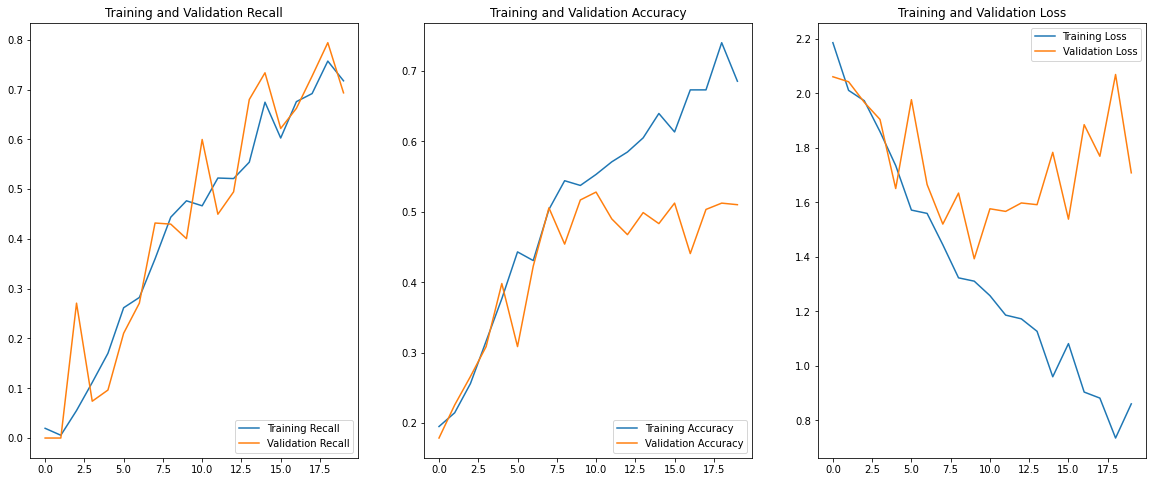

In [23]:
rec = history.history['recall']
val_rec = history.history['val_recall']

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(20)

plt.figure(figsize=(20, 8))
plt.subplot(1, 3, 1)
plt.plot(epochs_range, rec, label='Training Recall')
plt.plot(epochs_range, val_rec, label='Validation Recall')
plt.legend(loc='lower right')
plt.title('Training and Validation Recall')

plt.subplot(1, 3, 2)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 3, 3)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Findings after the model fit, see if there is an evidence of model overfit or underfit

#### Observations on the output of the base CNN model

- After 20 epochs, the train accuracy is 70.31% and validation accuracy is 40.27%. Thus, there is a difference of 30.04%.
- The train and validation losses follow similar trend till epoch 5 and then validation losses start increasing.
- From the aforementioned observations, we can safely say that the model is overfitting.

In [24]:
# After we have analysed the model fit history for presence of underfit or overfit, we chose an appropriate data augmentation strategy. 
# The code goes here:
data_aug = keras.Sequential([
                             layers.experimental.preprocessing.RandomFlip(mode="horizontal_and_vertical",input_shape=(img_height,img_width,3)),
                             layers.experimental.preprocessing.RandomRotation(0.2, fill_mode='reflect'),
                             layers.experimental.preprocessing.RandomZoom(height_factor=(0.2, 0.3), width_factor=(0.2, 0.3), fill_mode='reflect')
])

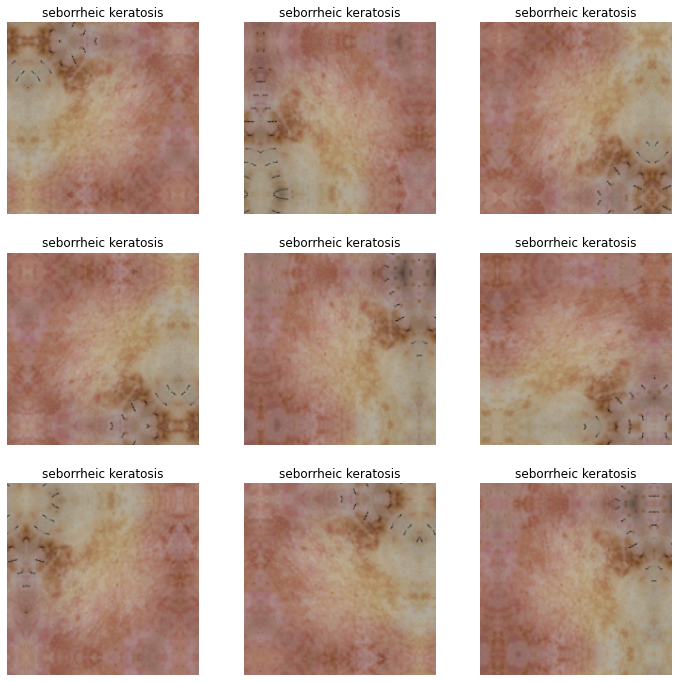

In [32]:
# Visualize how our augmentation strategy works for one instance of training image.
# The code goes here:
plt.figure(figsize=(12, 12))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(data_aug(images)[1].numpy().astype("uint8"))
        plt.title(class_names[labels[1]])
        plt.axis("off")

In [42]:
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D

def build_model_2(hp):  
  model = keras.Sequential([data_aug, layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))])
      
  model.add(Conv2D(
        filters=hp.Int('conv_1_filter', min_value = 32, max_value = 128, step = 16),
        kernel_size=hp.Choice('conv_1_kernel', values = [3,5]),
        activation='relu',
        input_shape=(180, 180, 3, 32)
    )),
  model.add(Conv2D(
        filters=hp.Int('conv_2_filter', min_value=32, max_value=128, step=16),
        kernel_size=hp.Choice('conv_2_kernel', values = [3,5]),
        activation='relu'
    )),
  model.add(MaxPool2D(pool_size=(2,2))),
  model.add(Dropout(0.25)),
    
  model.add(Conv2D(
        filters=hp.Int('conv_3_filter', min_value=32, max_value=128, step=16),
        kernel_size=hp.Choice('conv_3_kernel', values = [3,5]),
        activation='relu'
    )),
  model.add(MaxPool2D(pool_size=(2,2))),
    
  model.add(Conv2D(
        filters=hp.Int('conv_4_filter', min_value=32, max_value=128, step=16),
        kernel_size=hp.Choice('conv_4_kernel', values = [3,5]),
        activation='relu'
    )),
  model.add(MaxPool2D(pool_size=(2,2))),
  model.add(Dropout(0.25)),
                           
  model.add(Flatten()),
  # model.add(Dropout(0.5)),
  #model.add(Dense(
        #units=hp.Int('dense_1_units', min_value=0, max_value=128, step=16),
        #activation='relu'
    #)),
  # model.add(Dropout(0.5)),
  model.add(Dense(9, activation='softmax'))
  
  model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3])),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
  return model

In [43]:
tuner_search_2=RandomSearch(build_model_2, objective='accuracy', max_trials = 50,directory='trial_output_2',
                            project_name="DMML2_CA1_2")

In [44]:
tuner_search_2.search(train_ds, epochs=20)

Trial 50 Complete [00h 01m 13s]
accuracy: 0.2064732164144516

Best accuracy So Far: 0.5747767686843872
Total elapsed time: 01h 28m 20s
INFO:tensorflow:Oracle triggered exit


In [ ]:
# Again, in order to get recall along with the accuracy, implementing the best model manually:

### Create the model, compile and train the model

In [45]:
## One can use Dropout layer if there is an evidence of overfitting in the findings

## The code goes here

model_2 = Sequential([data_aug, layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))])


model_2.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu', input_shape = (180, 180, 3, 32)))
model_2.add(Conv2D(filters = 96, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model_2.add(MaxPool2D(pool_size=(2,2)))
model_2.add(Dropout(0.25))

model_2.add(Conv2D(filters = 96, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model_2.add(MaxPool2D(pool_size=(2,2)))
model_2.add(Dropout(0.25))

model_2.add(Conv2D(filters = 112, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model_2.add(MaxPool2D(pool_size=(2,2)))
model_2.add(Dropout(0.25))

model_2.add(Flatten())

model_2.add(Dense(9, activation = "softmax"))

In [46]:
# summary of the model
print(model_2.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 180, 180, 64)      1792      
                                                                 
 conv2d_5 (Conv2D)           (None, 180, 180, 96)      55392     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 96)       0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 90, 90, 96)        0         
                                                      

### Compiling the model

In [47]:
opt = keras.optimizers.Adam(learning_rate=0.001)
model_2.compile(optimizer=opt,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=[recall, 'accuracy'])

### Training the model

In [48]:
history = model_2.fit(
  train_ds,
  validation_data=val_ds,
  epochs=20
)

Epoch 1/20
56/56 [==============================] - 7s 94ms/step - loss: 2.1328 - recall: 0.0033 - accuracy: 0.1830 - val_loss: 2.0594 - val_recall: 0.0000e+00 - val_accuracy: 0.2058
Epoch 2/20
56/56 [==============================] - 4s 75ms/step - loss: 1.9208 - recall: 0.0564 - accuracy: 0.2930 - val_loss: 1.6622 - val_recall: 0.1186 - val_accuracy: 0.3848
Epoch 3/20
56/56 [==============================] - 4s 77ms/step - loss: 1.7344 - recall: 0.1719 - accuracy: 0.3795 - val_loss: 1.6880 - val_recall: 0.1413 - val_accuracy: 0.4004
Epoch 4/20
56/56 [==============================] - 5s 83ms/step - loss: 1.6770 - recall: 0.1959 - accuracy: 0.3890 - val_loss: 1.6273 - val_recall: 0.2508 - val_accuracy: 0.4273
Epoch 5/20
56/56 [==============================] - 5s 84ms/step - loss: 1.5905 - recall: 0.2522 - accuracy: 0.4235 - val_loss: 1.5723 - val_recall: 0.2105 - val_accuracy: 0.4273
Epoch 6/20
56/56 [==============================] - 5s 84ms/step - loss: 1.5445 - recall: 0.2718 - ac

### Visualizing the results

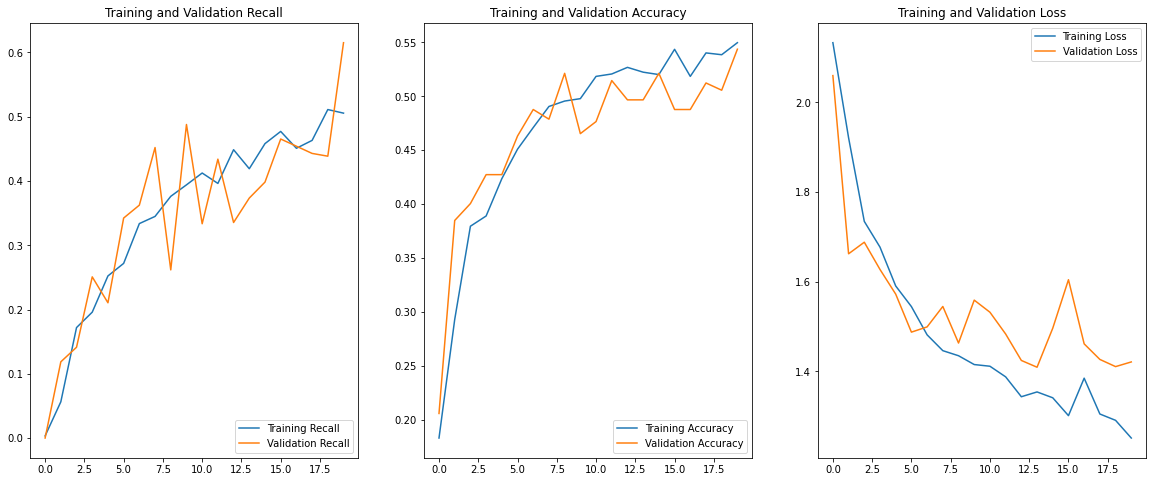

In [49]:
rec = history.history['recall']
val_rec = history.history['val_recall']

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(20)

plt.figure(figsize=(20, 8))
plt.subplot(1, 3, 1)
plt.plot(epochs_range, rec, label='Training Recall')
plt.plot(epochs_range, val_rec, label='Validation Recall')
plt.legend(loc='lower right')
plt.title('Training and Validation Recall')

plt.subplot(1, 3, 2)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 3, 3)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

#### Writing our findings after the model fit, see if there is an evidence of model overfit or underfit. Does one think there is some improvement now as compared to the previous model run?

#### Observations on the output of the base CNN model

- After 20 epochs, the train accuracy is 54.97% and validation accuracy is 54.36%. Thus, there is a difference of 0.61%.
- The train and validation losses follow similar trend till epoch 6 and then validation losses start increasing.
- From the aforementioned observations, we can see that the model is better than the base model as there is no evidence of overfitting or underfitting. However, the accuracies of both train and test are in 50's. There is a lot of room for improvement here.

## Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [50]:
path_list=[]
lesion_list=[]

for i in class_names:      
    for j in data_dir_train.glob(i+'/*.jpg'):
        path_list.append(str(j))
        lesion_list.append(i)

dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df

,Path,Label
0,Skin cancer ISIC The International Skin Imagin...,actinic keratosis
1,Skin cancer ISIC The International Skin Imagin...,actinic keratosis
2,Skin cancer ISIC The International Skin Imagin...,actinic keratosis
3,Skin cancer ISIC The International Skin Imagin...,actinic keratosis
4,Skin cancer ISIC The International Skin Imagin...,actinic keratosis
...,...,...
2234,Skin cancer ISIC The International Skin Imagin...,vascular lesion
2235,Skin cancer ISIC The International Skin Imagin...,vascular lesion
2236,Skin cancer ISIC The International Skin Imagin...,vascular lesion
2237,Skin cancer ISIC The International Skin Imagin...,vascular lesion


In [51]:
original_df['Label'].value_counts()

pigmented benign keratosis    462
melanoma                      438
basal cell carcinoma          376
nevus                         357
squamous cell carcinoma       181
vascular lesion               139
actinic keratosis             114
dermatofibroma                 95
seborrheic keratosis           77
Name: Label, dtype: int64

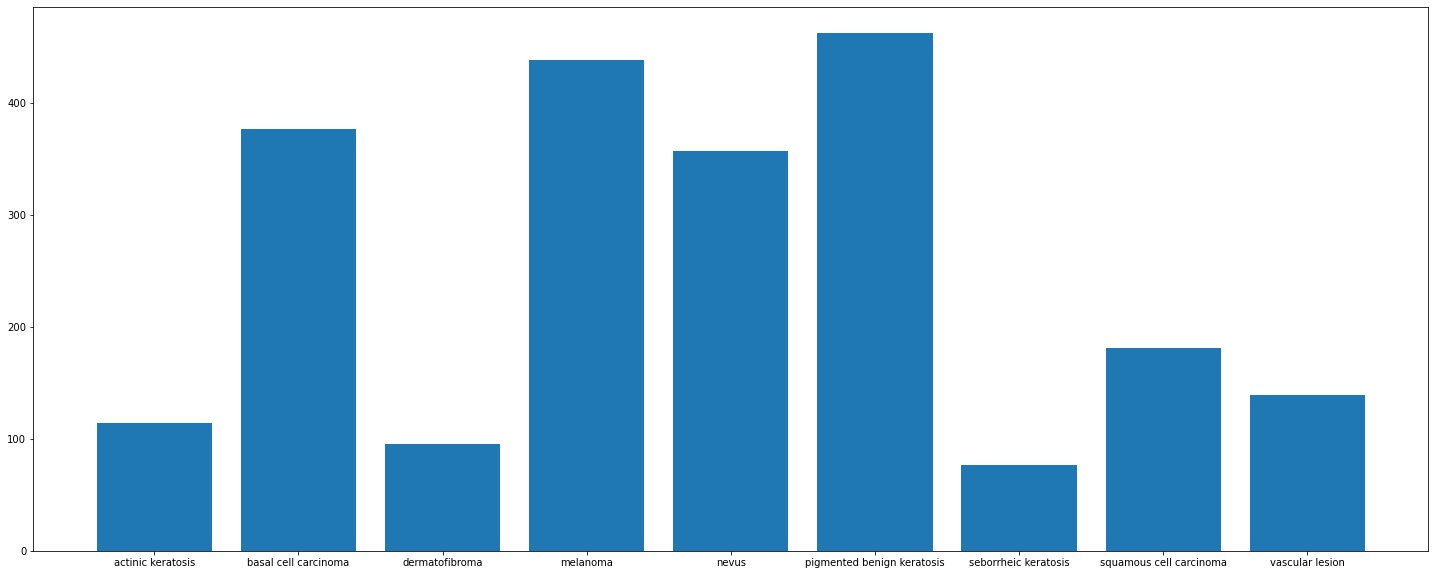

In [52]:
count=[]
for i in class_names:
    count.append(len(list(data_dir_train.glob(i+'/*.jpg'))))
plt.figure(figsize=(25,10))
plt.bar(class_names,count)
plt.show()

#### Which class has the least number of samples?
- Answer: seborrheic keratosis: Frequency = 77

#### Which classes dominate the data in terms proportionate number of samples?
- Answer: pigmented benign keratosis: Frequency = 462

#### **Context:** One can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [53]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing our initial image data set.<br>
2. Define a number of operations to perform on this data set using our `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [54]:
path_to_training_dataset= "Skin cancer ISIC The International Skin Imaging Collaboration//Train//"

# path_to_training_dataset="C:\\Users\\s_vaj\\Documents\\Academics\\upGrad\\Deep Learning\\Module 3 - CNN Assignment\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\"

import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration//Train//actinic keratosis\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x1CF092C5940>: 100%|██████████| 500/500 [00:01<00:00, 333.00 Samples/s]


Initialised with 376 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration//Train//basal cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1CF0930FFD0>: 100%|██████████| 500/500 [00:01<00:00, 336.20 Samples/s]                  


Initialised with 95 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration//Train//dermatofibroma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1CF092DE370>: 100%|██████████| 500/500 [00:01<00:00, 308.00 Samples/s]                  


Initialised with 438 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration//Train//melanoma\output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x1CF08DB8250>: 100%|██████████| 500/500 [00:08<00:00, 59.38 Samples/s]                   


Initialised with 357 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration//Train//nevus\output.

Processing <PIL.Image.Image image mode=RGB size=1504x1129 at 0x1CF0929AA90>: 100%|██████████| 500/500 [00:06<00:00, 76.70 Samples/s]                   


Initialised with 462 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration//Train//pigmented benign keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1CF08DB6C10>: 100%|██████████| 500/500 [00:01<00:00, 333.47 Samples/s]                  


Initialised with 77 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration//Train//seborrheic keratosis\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x1CF092816A0>: 100%|██████████| 500/500 [00:03<00:00, 137.16 Samples/s]


Initialised with 181 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration//Train//squamous cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1CF08BCCA90>: 100%|██████████| 500/500 [00:01<00:00, 307.79 Samples/s]                  


Initialised with 139 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration//Train//vascular lesion\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1CF092B0940>: 100%|██████████| 500/500 [00:01<00:00, 318.03 Samples/s]                  


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [55]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [56]:
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new

['Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_0bcce065-bcc7-495b-bde8-ce5d13d975fd.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_3a6f47a3-72e0-4595-8db3-c6057bec8d34.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_542a96a6-d0f3-4e05-b51e-910118101675.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_7abbd797-520a-425d-97a3-6213361078e4.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_87c49721-2a26-4c2a-a5db-22e56a9da2c1.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration\\Train

In [57]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [58]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [59]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

In [60]:
new_df['Label'].value_counts()

pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### Train the model on the data created using Augmentor

In [80]:
batch_size = 64
img_height = 180
img_width = 180

#### Create a training dataset

In [81]:
# data_dir_train="Skin cancer ISIC The International Skin Imaging Collaboration/Train"

data_dir_train="Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training', ## Choose the correct parameter value, so that only training data is refered to,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### Create a validation dataset

In [82]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation', ## Choose the correct parameter value, so that only validation data is refered to,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [88]:
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D

def build_model_3(hp):  
  model = keras.Sequential([layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))])
      
  model.add(Conv2D(
        filters=hp.Int('conv_1_filter', min_value = 32, max_value = 40, step = 16),
        kernel_size=hp.Choice('conv_1_kernel', values = [3,5]),
        activation='relu',
        input_shape=(180, 180, 3)
    )),
  model.add(Conv2D(
        filters=hp.Int('conv_2_filter', min_value=64, max_value=72, step=16),
        kernel_size=hp.Choice('conv_2_kernel', values = [3,5]),
        activation='relu'
    )),
  model.add(MaxPool2D(pool_size=(2,2))),
  model.add(Dropout(0.25)),
    
  model.add(Conv2D(
        filters=hp.Int('conv_3_filter', min_value=128, max_value=136, step=16),
        kernel_size=hp.Choice('conv_3_kernel', values = [3,5]),
        activation='relu'
    )),
  model.add(MaxPool2D(pool_size=(2,2))),
    
  model.add(Conv2D(
        filters=hp.Int('conv_4_filter', min_value=256, max_value=264, step=16),
        kernel_size=hp.Choice('conv_4_kernel', values = [3,5]),
        activation='relu'
    )),
  model.add(MaxPool2D(pool_size=(2,2))),
  model.add(Dropout(0.25)),
                           
  model.add(Flatten()),
  # model.add(Dropout(0.5)),
  model.add(Dense(
        units=hp.Int('dense_1_units', min_value=512, max_value=520, step=16),
        activation='relu'
    )),
  model.add(Dropout(0.5)),
  model.add(Dense(9, activation='softmax'))
  # Using the learning rate = 0.001 as in the last two models, this is the best learning rate between 0.01 and 0.001:
  model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-3])),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
  return model

In [89]:
tuner_search_3=RandomSearch(build_model_3, objective='accuracy', max_trials = 20, directory='trial_output_3',
                            project_name="DMML2_CA1_3")

In [90]:
tuner_search_3.search(train_ds, epochs=20)

Trial 12 Complete [00h 04m 19s]
accuracy: 0.7477744817733765

Best accuracy So Far: 0.9063427448272705
Total elapsed time: 00h 45m 47s
INFO:tensorflow:Oracle triggered exit


#### Creating the model

In [132]:
## The code goes here

model_3 = Sequential([layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))])


model_3.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', activation ='relu', input_shape = (180, 180, 32)))
model_3.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model_3.add(MaxPool2D(pool_size=(2,2)))
model_3.add(Dropout(0.25))

model_3.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model_3.add(MaxPool2D(pool_size=(2,2)))
model_3.add(Dropout(0.25))

model_3.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model_3.add(MaxPool2D(pool_size=(2,2)))
model_3.add(Dropout(0.25))

model_3.add(Conv2D(filters = 256, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model_3.add(MaxPool2D(pool_size=(2,2)))
model_3.add(Dropout(0.25))


model_3.add(Flatten())
model_3.add(Dense(512))
model_3.add(Activation('relu'))
model_3.add(Dropout(0.5))

model_3.add(Dense(num_classes, activation = "softmax"))

In [133]:
# summary of the model
print(model_3.summary())

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_5 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_20 (Conv2D)          (None, 180, 180, 32)      896       
                                                                 
 conv2d_21 (Conv2D)          (None, 180, 180, 32)      9248      
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 90, 90, 32)       0         
 g2D)                                                            
                                                                 
 dropout_15 (Dropout)        (None, 90, 90, 32)        0         
                                                                 
 conv2d_22 (Conv2D)          (None, 90, 90, 64)        18496     
                                                      

In [136]:
## The code goes here
opt = keras.optimizers.Adam(learning_rate=0.001)
model_3.compile(optimizer=opt,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=[recall, 'accuracy'])

In [137]:
epochs = 20

history = model_3.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
85/85 [==============================] - 9s 89ms/step - loss: 2.1921 - recall: 0.0142 - accuracy: 0.1461 - val_loss: 2.0692 - val_recall: 0.0284 - val_accuracy: 0.2197
Epoch 2/20
85/85 [==============================] - 7s 82ms/step - loss: 2.1438 - recall: 0.0267 - accuracy: 0.1751 - val_loss: 2.0830 - val_recall: 0.0199 - val_accuracy: 0.2168
Epoch 3/20
85/85 [==============================] - 8s 85ms/step - loss: 1.8809 - recall: 0.1044 - accuracy: 0.2821 - val_loss: 1.6794 - val_recall: 0.1442 - val_accuracy: 0.3734
Epoch 4/20
85/85 [==============================] - 8s 90ms/step - loss: 1.5904 - recall: 0.2309 - accuracy: 0.3926 - val_loss: 1.5689 - val_recall: 0.1918 - val_accuracy: 0.3972
Epoch 5/20
85/85 [==============================] - 8s 91ms/step - loss: 1.4863 - recall: 0.2936 - accuracy: 0.4397 - val_loss: 1.6329 - val_recall: 0.2386 - val_accuracy: 0.3705
Epoch 6/20
85/85 [==============================] - 8s 90ms/step - loss: 1.3329 - recall: 0.3785 - accura

#### Visualize the model results

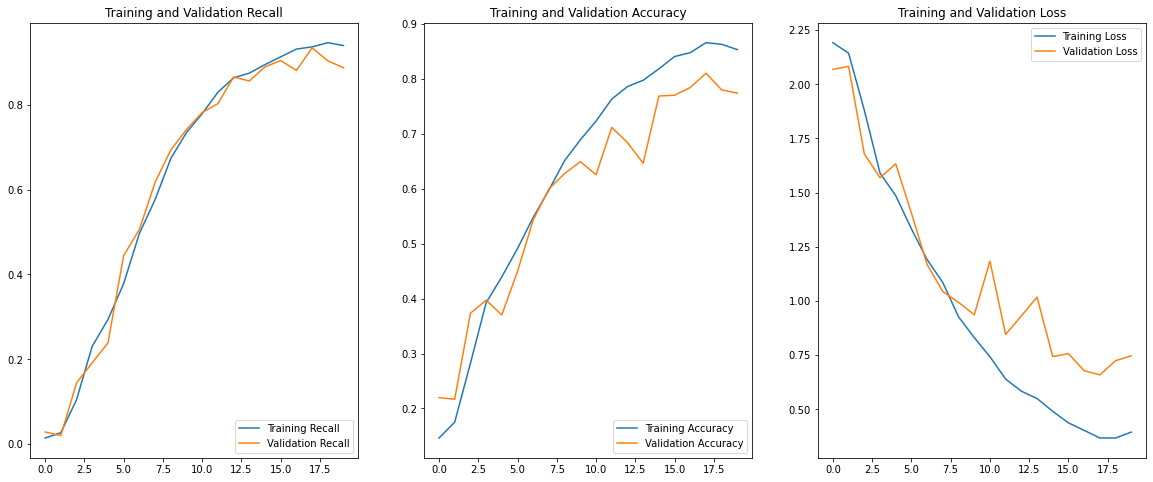

In [138]:
rec = history.history['recall']
val_rec = history.history['val_recall']

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(20)

plt.figure(figsize=(20, 8))
plt.subplot(1, 3, 1)
plt.plot(epochs_range, rec, label='Training Recall')
plt.plot(epochs_range, val_rec, label='Validation Recall')
plt.legend(loc='lower right')
plt.title('Training and Validation Recall')

plt.subplot(1, 3, 2)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 3, 3)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

#### Did we get rid of underfitting/overfitting? Did class rebalance help?



#### Observations on the output of the base CNN model

- After 20 epochs, the train accuracy is 85.37% and validation accuracy is 77.43%. Thus, there is a difference of 7.94%.
- The train and validation losses follow similar trend till epoch 9 and then validation losses start increasing and then follow marginally doward trend beween epochs 14 and 16 and then there is an uptick again during the epochs 17 and 20.
- From the aforementioned observations, we can see that the model is much better than the previous models as there is no evidence of overfitting or underfitting. Moreover, the accuracies have improved significantly.
- Class rebalance helped significantly in improving the train and validation accuracies.
- Train and validation recalls are 94.01% and 88.78% respectively at epoch 20. Thus, there is a difference of 5.23%.
- Overall, it became clear to us that better models can be built using more layers, dropouts and class rebalancing.

### Creating the test dataset

In [139]:
# data_dir_train="Skin cancer ISIC The International Skin Imaging Collaboration/Train"

data_dir_test="Skin cancer ISIC The International Skin Imaging Collaboration\\Test\\"
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_test,
  seed=123,
  labels='inferred',
  label_mode='int',
  # validation_split = 0.99, # This is optional,
  # source: https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory
  # subset = 'validation', ## Only used if validation_split is set,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 118 files belonging to 9 classes.


In [140]:
test_ds.class_names

['actinic keratosis',
 'basal cell carcinoma',
 'dermatofibroma',
 'melanoma',
 'nevus',
 'pigmented benign keratosis',
 'seborrheic keratosis',
 'squamous cell carcinoma',
 'vascular lesion']

In [141]:
score = model_3.evaluate(test_ds, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 3.7724666595458984
Test accuracy: 0.8214699029922485


In [142]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
    rotation_range=180,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest',
  )
test_generator = datagen.flow_from_directory(
    data_dir_test,
    target_size=(180, 180),
    batch_size=1,
    class_mode='categorical',
    shuffle=False
)
datagen = ImageDataGenerator()
test_gen = datagen.flow_from_directory(
    data_dir_test,
    target_size=(180, 180),
    batch_size=1,
    class_mode='categorical',
    shuffle=False)

Found 118 images belonging to 9 classes.
Found 118 images belonging to 9 classes.


In [143]:
from sklearn.metrics import classification_report
preds = model_3.predict(test_gen)
preds_list = []

for pred in preds:
  preds_list.append(np.argmax(pred))

report = classification_report(test_gen.classes, preds_list)

print(report)

              precision    recall  f1-score   support

           0       0.75      0.19      0.30        16
           1       0.29      0.31      0.30        16
           2       0.67      0.25      0.36        16
           3       0.23      0.19      0.21        16
           4       0.27      0.44      0.33        16
           5       0.28      0.69      0.39        16
           6       0.00      0.00      0.00         3
           7       0.60      0.38      0.46        16
           8       1.00      0.67      0.80         3

    accuracy                           0.35       118
   macro avg       0.45      0.34      0.35       118
weighted avg       0.44      0.35      0.34       118



C:\Users\Amit\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Amit\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Amit\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


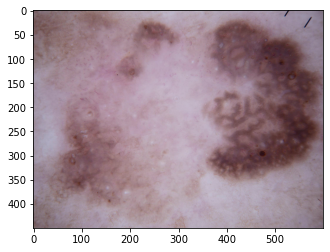

In [144]:
img_path = "Skin cancer ISIC The International Skin Imaging Collaboration\\Test\\pigmented benign keratosis\\ISIC_0024381.jpg"
test_img = mpimg.imread(img_path)
plt.imshow(test_img)
plt.show()

In [145]:
from keras.preprocessing.image import img_to_array, array_to_img
from keras.preprocessing import image

# image = img_to_array(image.load_img(x, target_size=(128,128))) / 255

# tf.keras.utils.img_to_array(
    #img, data_format=None, dtype=None
#)

# loaded_img = img_to_array(image.load_img(test_img, target_size=(224, 224)))

In [146]:
img = image.load_img(img_path, target_size=(180, 180))

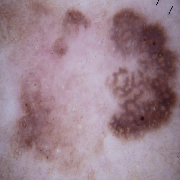

In [147]:
img

In [148]:
img_array = image.img_to_array(img)
img_batch = np.expand_dims(img_array, axis=0)

In [149]:
from keras.applications.imagenet_utils import preprocess_input
img_preprocessed = preprocess_input(img_batch)

In [150]:
result = model_3.predict(img_preprocessed)
result

array([[0.09144442, 0.13372967, 0.08470006, 0.1383182 , 0.12634137,
        0.14360115, 0.08411313, 0.10621687, 0.09153515]], dtype=float32)

In [151]:
np.shape(result)

(1, 9)

In [152]:
np.shape(result[0])

(9,)

In [153]:
prediction = np.argmax(result[0])
prediction

5

In [154]:
a = np.amax(result[0])
a

0.14360115

In [155]:
index = np.where(result[0] == a)
index

(array([5], dtype=int64),)

In [156]:
index[0][0]

5

In [157]:
class_names

['actinic keratosis',
 'basal cell carcinoma',
 'dermatofibroma',
 'melanoma',
 'nevus',
 'pigmented benign keratosis',
 'seborrheic keratosis',
 'squamous cell carcinoma',
 'vascular lesion']

In [158]:
if index[0][0] == 0:
    print("Predicted class = 'Actinic Keratosis'")
if index[0][0] == 1:
    print("Predicted class = 'Basal Cell Carcinoma'")
if index[0][0] == 2:
    print("Predicted class = 'Dermatofibroma'")
if index[0][0] == 3:
    print("Predicted class = 'Melanoma'")
if index[0][0] == 4:
    print("Predicted class = 'nevus'")
if index[0][0] == 5:
    print("Predicted class = 'Pigmented Benign Keratosis'")
if index[0][0] == 6:
    print("Predicted class = Sebhorreic Keratosis'")
if index[0][0] == 7:
    print("Predicted class = 'Sqamous Cell Carcinoma'")
if index[0][0] == 8:
    print("Predicted class = 'Vascular Lesion'")

Predicted class = 'Pigmented Benign Keratosis'
